In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from imodels import RuleListClassifier, RuleFit, SLIM, GreedyRuleList
from sklearn.tree import DecisionTreeClassifier, plot_tree
import sys
sys.path.append('../src')

import data
import validate
from tqdm import tqdm 

outcome_def = 'iai_intervention' # output
%matplotlib inline
%load_ext autoreload
%autoreload 2

df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=True)
df = df_pecarn[common_feats].append(df_psrc[common_feats])
processed_feats = data.select_final_feats(common_feats)

train_idxs = data.pecarn_train_idxs
df = df[df.cv_fold.isin(train_idxs)]
print(len(processed_feats), processed_feats)
X, y = df[processed_feats], df[outcome_def]

# look at different buckets

In [ ]:
bucket_counts = {}
for i in tqdm(range(X.shape[0])): #X.shape[0]):
    x = X.iloc[i]
    s = ''.join(x.values.astype(int).astype(str).tolist())
    ylab = y.iloc[i]
    if not s in bucket_counts:
        bucket_counts[s] = [0, 0]
        bucket_counts[s][ylab] = 1
    else:
        bucket_counts[s][ylab] += 1

In [96]:
vals = np.array([x for x in bucket_counts.values()]) # n x 2
counts_per_bucket = vals.sum(axis=1).flatten() # n
purities = vals[:, 1] / vals.sum(axis=1) # n 
is_pure = (purities==0) | (purities==1)
num_pure_buckets = np.sum(is_pure)
num_pts_in_pure = counts_per_bucket[is_pure].sum()

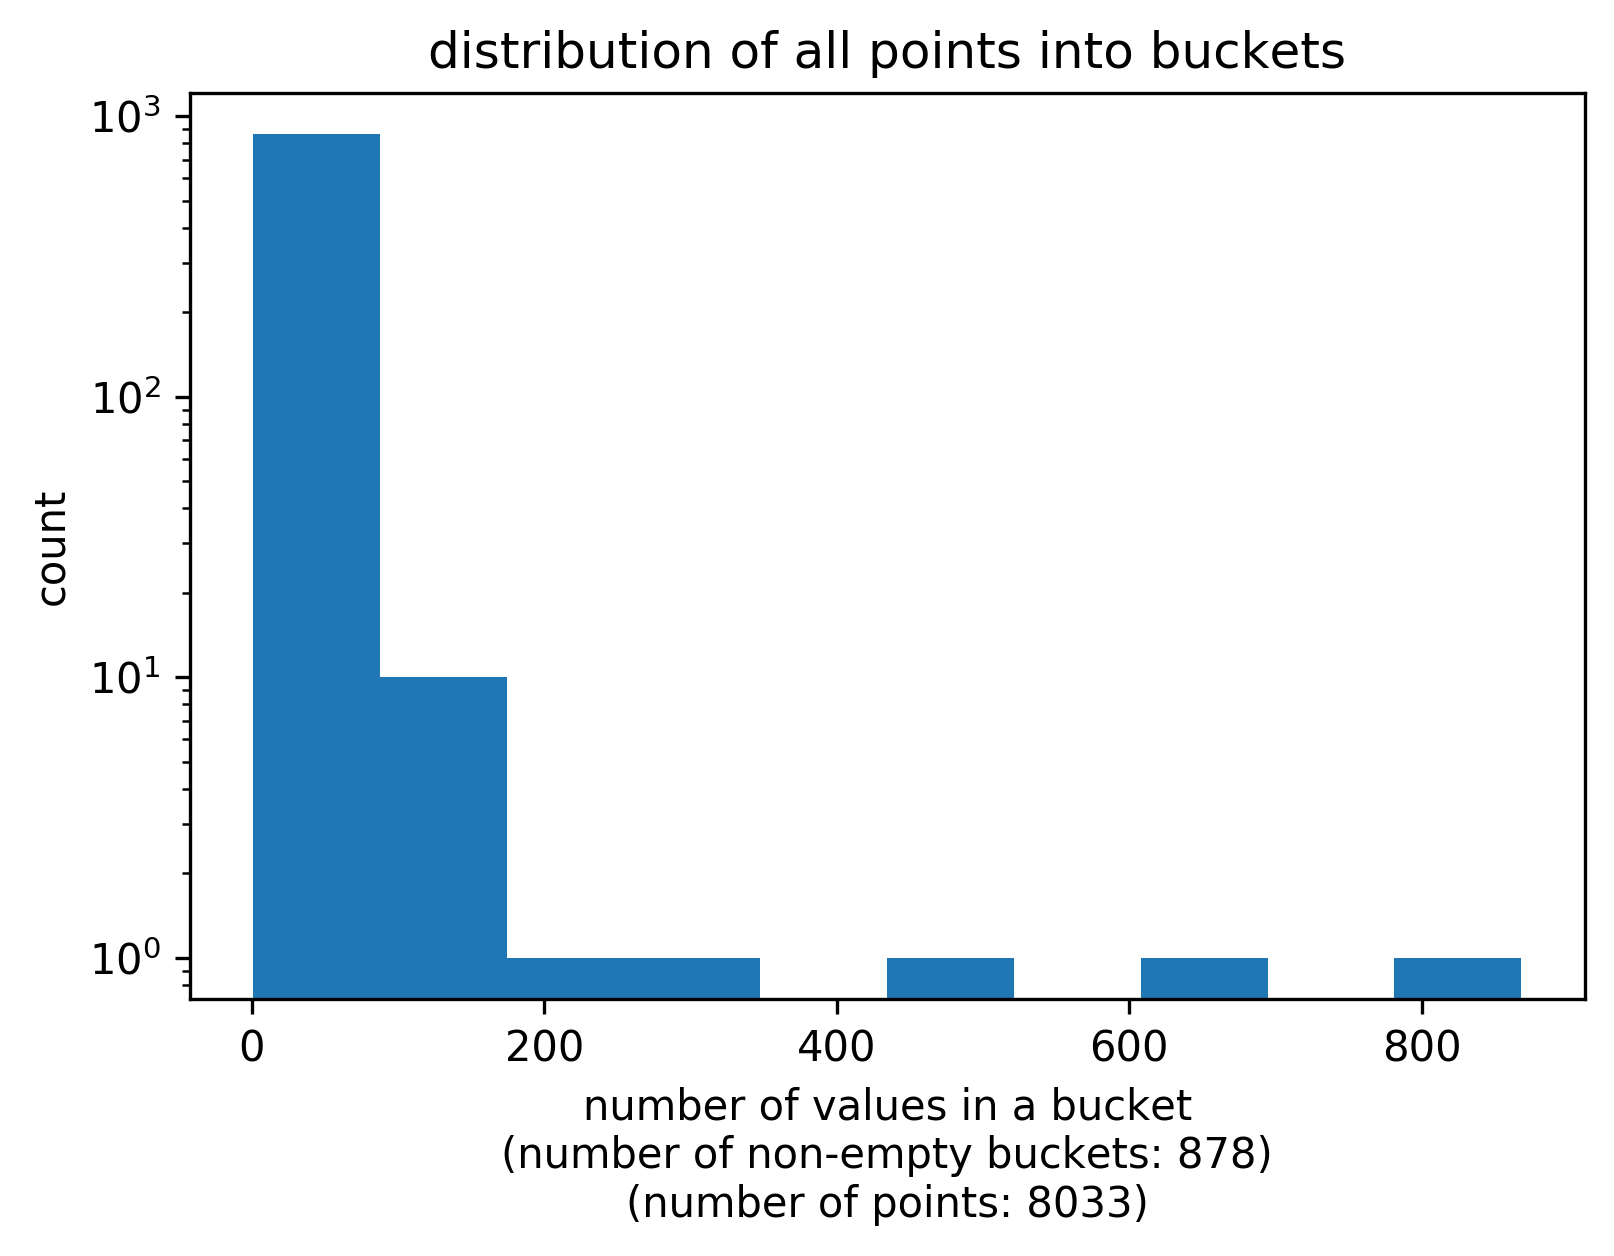

In [100]:
plt.figure(dpi=300)
plt.hist(counts_per_bucket, log=True)
plt.yscale('log')
plt.ylabel('count')
plt.title('distribution of all points into buckets')
plt.xlabel(f'number of values in a bucket\n(number of non-empty buckets: {vals.shape[0]})\n(number of points: {X.shape[0]})')
plt.show()

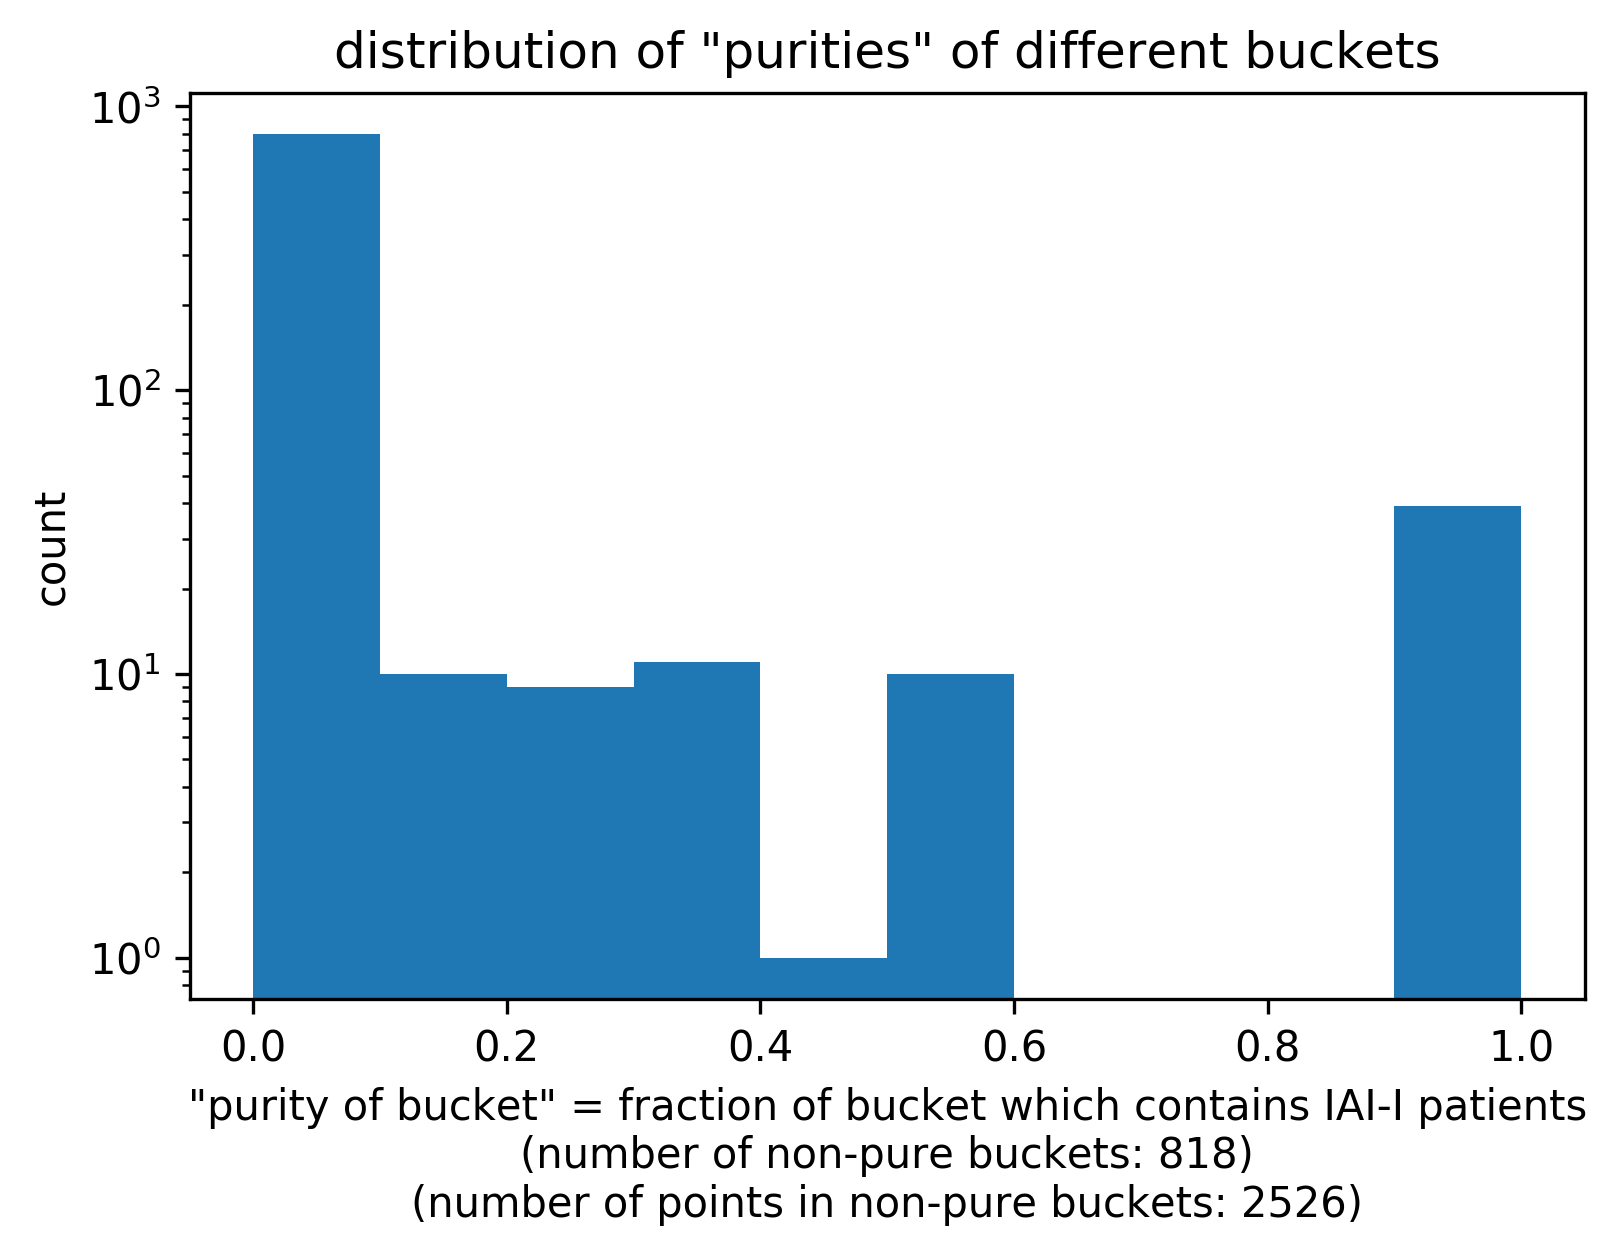

In [101]:
plt.figure(dpi=300)
plt.hist(purities.flatten(), log=True)
plt.yscale('log')
plt.ylabel('count')
plt.title('distribution of "purities" of different buckets')
plt.xlabel(f'"purity of bucket" = fraction of bucket which contains IAI-I patients\n(number of non-pure buckets: {num_pure_buckets})\n(number of points in non-pure buckets: {X.shape[0] - num_pts_in_pure})')
plt.show()

In [ ]:
# preds = purities >= 0.5
# num_fp = purities > 0.5 
# print('number of mistakes predicting the majority class for each bucket', )

# fit simple models

**decision tree**

  0%|          | 0/7 [00:00<?, ?it/s]/accounts/projects/vision/.local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1268: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
100%|██████████| 7/7 [00:00<00:00, 137.80it/s]


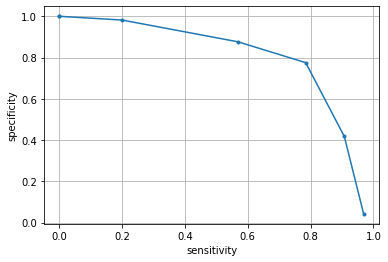

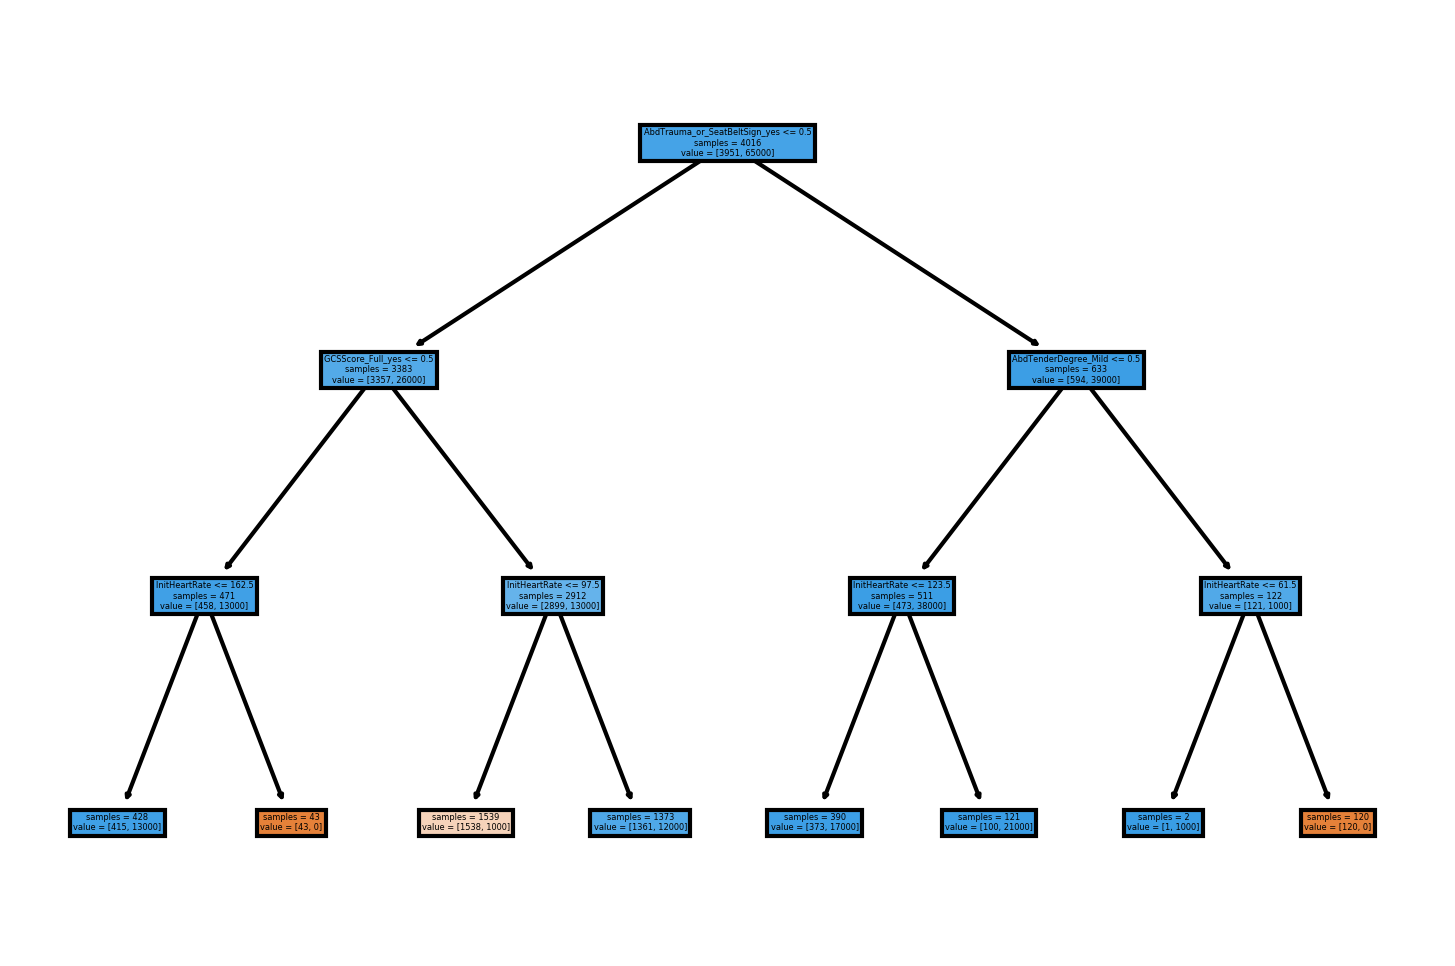

In [5]:
# specify a decision tree with a maximum depth
dt = DecisionTreeClassifier(max_depth=3, class_weight={0:1, 1:1e3})
dt.fit(X_train, y_train)

# calculat mse on the training data
preds = dt.predict(X_test)
preds_proba = dt.predict_proba(X_test)
# print(preds)
sens, spec, threshes = validate.sensitivity_specificity_curve(y_test, preds_proba[:, 1])

# print(f'test: {np.mean(np.square(preds-y_test)):0.2f}')
# print(sklearn.metrics.classification_report(y_test, preds))
plt.figure(dpi=300)
plot_tree(dt, feature_names=processed_feats, impurity=False, filled=True)
# plt.savefig('tree.pdf')
plt.show()